In [69]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import KFold

In [2]:
df = pd.read_csv('C:\\Users\\ellen\\Downloads\\bank+marketing\\bank\\bank-full.csv', sep =';')

In [3]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [4]:
df = df[['age','job','marital','education','balance','housing', 'contact','day','month','duration','campaign','pdays','previous','poutcome','y']]

Split the data in three parts:

In [5]:
df.y = (df.y=='yes').astype(int)

In [105]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

## 1. ROC AUC could also be used to evaluate feature importance of numerical variables.

In [7]:
df_train.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
14137,56,entrepreneur,married,tertiary,40,no,cellular,11,jul,123,2,-1,0,unknown,0
33506,33,technician,married,secondary,4790,yes,cellular,20,apr,137,1,272,2,failure,0
27524,32,technician,single,tertiary,392,yes,cellular,21,nov,148,2,-1,0,unknown,0
34058,40,admin.,divorced,secondary,2129,no,cellular,30,apr,452,1,-1,0,unknown,1
25922,54,unemployed,married,tertiary,1180,no,cellular,19,nov,394,2,-1,0,unknown,0


In [8]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [9]:
df.head()

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,2143,yes,unknown,5,may,261,1,-1,0,unknown,0
1,44,technician,single,secondary,29,yes,unknown,5,may,151,1,-1,0,unknown,0
2,33,entrepreneur,married,secondary,2,yes,unknown,5,may,76,1,-1,0,unknown,0
3,47,blue-collar,married,unknown,1506,yes,unknown,5,may,92,1,-1,0,unknown,0
4,33,unknown,single,unknown,1,no,unknown,5,may,198,1,-1,0,unknown,0


To check what is numerical and what is categorical:

In [10]:
df.dtypes

age           int64
job          object
marital      object
education    object
balance       int64
housing      object
contact      object
day           int64
month        object
duration      int64
campaign      int64
pdays         int64
previous      int64
poutcome     object
y             int32
dtype: object

In [20]:
#df.y

In [11]:
y_train = df_train.y
y_val = df_val.y

del df_train['y']
del df_val['y']

Which numerical variable (among the following 4) has the highest AUC?

- balance
- day
- duration
- previous

In [19]:
y_train = y_train.reset_index(drop=True)
y_train

In [12]:
df_train['balance']

0          40
1        4790
2         392
3        2129
4        1180
         ... 
27121     195
27122    3720
27123     289
27124     312
27125     580
Name: balance, Length: 27126, dtype: int64

In [13]:
y_train

0        0
1        0
2        0
3        1
4        0
        ..
27121    0
27122    0
27123    0
27124    0
27125    0
Name: y, Length: 27126, dtype: int32

In [20]:
for var in ['balance', 'day', 'duration', 'previous']:
    print(var)
    score = roc_auc_score(y_train, df_train[var])
    if score < 0.5:
        score = roc_auc_score(y_train, df_train[var])
    print(score)

balance
0.5888313805382317
day
0.474042117616092
duration
0.8147002759670778
previous
0.5985653242764153


Answer: Duration has the highest score.

## Question 2: Apply one-hot-encoding using DictVectorizer and train the logistic regression with these parameters:

LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)

In [32]:
categorical = ['job', 'marital', 'education', 'housing', 'contact', 'month', 'poutcome']
numerical = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

In [22]:
df.shape

(45211, 15)

In [25]:
vars = categorical + numerical
len(vars)

14

In [30]:
train_dict = df_train[categorical + numerical].to_dict(orient='records')

In [33]:
dv = DictVectorizer(sparse=False)
dv.fit(train_dict)



DictVectorizer(sparse=False)

In [34]:
X_train = dv.transform(train_dict)

In [39]:
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [40]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_pred = model.predict_proba(X_val)[:, 1]

In [42]:
roc_auc_score(y_val, y_pred)

0.9003324959598795

In [ ]:
Answer: 0.89

## 3. Now let's compute precision and recall for our model.

- Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
- For each threshold, compute precision and recall
- Plot them

In [45]:
import numpy as np
thresholds = np.linspace(0, 1, 101)
thresholds

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

In [53]:
scores = []

for t in thresholds: #B
    tp = ((y_pred >= t) & (y_val == 1)).sum()
    fp = ((y_pred >= t) & (y_val == 0)).sum()
    fn = ((y_pred < t) & (y_val == 1)).sum()
    tn = ((y_pred < t) & (y_val == 0)).sum()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)

    scores.append((t, tp, fp, fn, tn, precision, recall))

df_scores = pd.DataFrame(scores)
df_scores.columns = ['threshold', 'tp', 'fp', 'fn', 'tn', 'precision', 'recall']

C:\Users\ellen\AppData\Local\Temp\ipykernel_16352\623529546.py:8: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


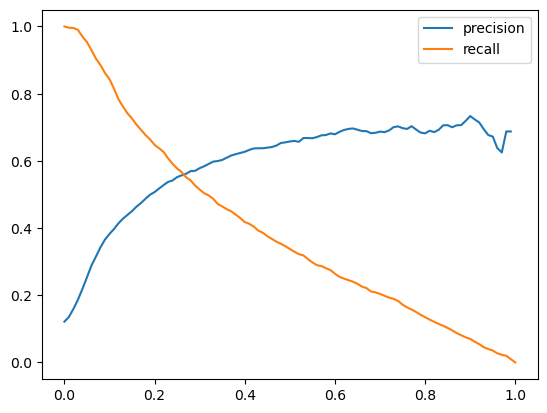

In [56]:
plt.plot(df_scores.threshold, df_scores.precision, label='precision')
plt.plot(df_scores.threshold, df_scores.recall, label='recall')

plt.legend()

Select row where precision and recall are the same:

In [64]:
df_small = df_scores[df_scores['threshold']<0.3]
df_small

,threshold,tp,fp,fn,tn,precision,recall
0,0.00,1098,7944,0,0,0.121433,1.000000
1,0.01,1094,6974,4,970,0.135597,0.996357
2,0.02,1093,5768,5,2176,0.159306,0.995446
3,0.03,1087,4727,11,3217,0.186963,0.989982
4,0.04,1065,3800,33,4144,0.218911,0.969945
5,0.05,1047,3086,51,4858,0.253327,0.953552
6,0.06,1021,2519,77,5425,0.288418,0.929872
7,0.07,993,2155,105,5789,0.315438,0.904372
8,0.08,972,1864,126,6080,0.342736,0.885246
9,0.09,946,1640,152,6304,0.365816,0.861566


Answer: The intersection occurs at 0.265

## Question 4: Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

In [66]:
scores = []

for t in thresholds: #B
    tp = ((y_pred >= t) & (y_val == 1)).sum()
    fp = ((y_pred >= t) & (y_val == 0)).sum()
    fn = ((y_pred < t) & (y_val == 1)).sum()
    tn = ((y_pred < t) & (y_val == 0)).sum()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1= (2*precision*recall)/(precision + recall)

    scores.append((t, tp, fp, fn, tn, precision, recall, f1))

df_scores = pd.DataFrame(scores)
df_scores.columns = ['threshold', 'tp', 'fp', 'fn', 'tn', 'precision', 'recall', 'f1']

C:\Users\ellen\AppData\Local\Temp\ipykernel_16352\3212830531.py:8: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


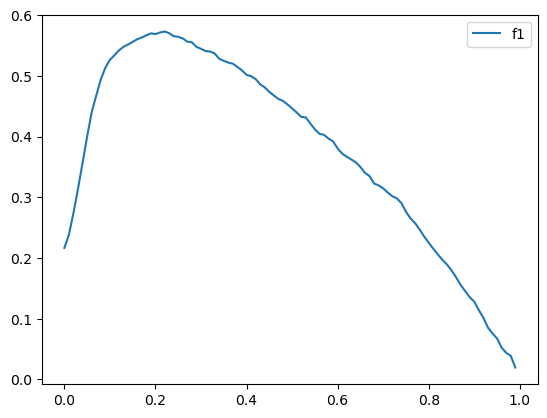

In [67]:
plt.plot(df_scores.threshold, df_scores.f1, label='f1')

plt.legend()

Answer: At the value of 0.22 the value is maximum.

## 5. Use the KFold class from Scikit-Learn to evaluate our model on 5 different folds:

KFold(n_splits=5, shuffle=True, random_state=1)

In [89]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

In [90]:
df_train

,age,job,marital,education,balance,housing,contact,day,month,duration,campaign,pdays,previous,poutcome,y
14137,56,entrepreneur,married,tertiary,40,no,cellular,11,jul,123,2,-1,0,unknown,0
33506,33,technician,married,secondary,4790,yes,cellular,20,apr,137,1,272,2,failure,0
27524,32,technician,single,tertiary,392,yes,cellular,21,nov,148,2,-1,0,unknown,0
34058,40,admin.,divorced,secondary,2129,no,cellular,30,apr,452,1,-1,0,unknown,1
25922,54,unemployed,married,tertiary,1180,no,cellular,19,nov,394,2,-1,0,unknown,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22520,32,technician,single,tertiary,195,yes,cellular,22,aug,239,2,-1,0,unknown,0
26678,52,self-employed,married,secondary,3720,no,cellular,20,nov,114,2,-1,0,unknown,0
4964,52,blue-collar,married,secondary,289,yes,unknown,21,may,45,13,-1,0,unknown,0
20083,32,management,married,tertiary,312,no,cellular,11,aug,67,4,-1,0,unknown,0


In [91]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [93]:
# y_train = df_train.y
# y_val = df_val.y

# del df_train['y']
# del df_val['y']

In [94]:
def train(df, y):
    cat = df[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X, y)

    return dv, model


def predict(df, dv, model):
    cat = df[categorical + numerical].to_dict(orient='records')
    
    X = dv.transform(cat)

    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [103]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [95]:
# df_train

In [106]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)

In [83]:
# df_train = df_train.reset_index(drop=True)
# df_val = df_val.reset_index(drop=True)
# df_test = df_test.reset_index(drop=True)

In [108]:
aucs = []

for train_idx, val_idx in kfold.split(df_train_full):
    df_train = df_train_full.iloc[train_idx]
    y_train = df_train.y.values

    df_val = df_train_full.iloc[val_idx]
    y_val = df_val.y.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    rocauc = roc_auc_score(y_val, y_pred)
    aucs.append(rocauc)

In [109]:
aucs

[0.8993883806356288,
 0.8989055268937651,
 0.9112102229960733,
 0.9080952264469403,
 0.9100912737695956]

In [112]:
np.std(aucs)

0.0053151357572693

The answer is closes to 0.006.

## Question 6: Now let's use 5-Fold cross-validation to find the best parameter C - [0.000001, 0.001, 1]

In [113]:
for c in [0.000001, 0.001, 1]:
    print(c)

1e-06
0.001
1


In [117]:
def train(df, y, C=1.0):
    cat = df[categorical + numerical].to_dict(orient='records')
    
    dv = DictVectorizer(sparse=False)
    dv.fit(cat)

    X = dv.transform(cat)

    model = LogisticRegression(solver='liblinear', C=C)
    model.fit(X, y)

    return dv, model

In [114]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

In [118]:
for C in [0.000001, 0.001, 1]:
    aucs = []

    for train_idx, val_idx in kfold.split(df_train_full):
        df_train = df_train_full.iloc[train_idx]
        df_val = df_train_full.iloc[val_idx]

        y_train = df_train.y
        y_val = df_val.y

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
        
        auc = roc_auc_score(y_val, y_pred)
        aucs.append(auc)

    print('C=%s, auc = %0.3f ± %0.3f' % (C, np.mean(aucs), np.std(aucs)))

C=1e-06, auc = 0.701 ± 0.009
C=0.001, auc = 0.861 ± 0.007
C=1, auc = 0.905 ± 0.005


c:\Users\ellen\miniconda3\envs\ml_ellen\lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Answer: C =  1 has the best mean score.